# <span style="color:#0b486b">Neural Network Assignment 01</span>


### Import Required Libraries

In [26]:
# Import necessary modules
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
import tensorflow.keras
from tensorflow.keras.utils import plot_model

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, concatenate, Input, Conv2D, MaxPooling2D, BatchNormalization, Maximum, ZeroPadding2D
from tensorflow.keras.optimizers import Adam, Adadelta, SGD, RMSprop
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [5]:
CLASS = {
    'Black-grass': 0,
    'Charlock': 1,
    'Cleavers': 2,
    'Common Chickweed': 3,
    'Common wheat': 4,
    'Fat Hen': 5,
    'Loose Silky-bent': 6,
    'Maize': 7,
    'Scentless Mayweed': 8,
    'Shepherds Purse': 9,
    'Small-flowered Cranesbill': 10,
    'Sugar beet': 11
}

INV_CLASS = {
    0: 'Black-grass',
    1: 'Charlock',
    2: 'Cleavers',
    3: 'Common Chickweed',
    4: 'Common wheat',
    5: 'Fat Hen',
    6: 'Loose Silky-bent',
    7: 'Maize',
    8: 'Scentless Mayweed',
    9: 'Shepherds Purse',
    10: 'Small-flowered Cranesbill',
    11: 'Sugar beet'
}

### Import Data (Select from Local Drive)

In [6]:
TRAIN_IMG_PATH = "./train"
classes = {}
for class_name in os.listdir(TRAIN_IMG_PATH):
    classes[class_name] = len(os.listdir(os.path.join(TRAIN_IMG_PATH, class_name)))
print(classes)

{'Black-grass': 263, 'Charlock': 390, 'Cleavers': 287, 'Common Chickweed': 611, 'Common wheat': 221, 'Fat Hen': 475, 'Loose Silky-bent': 654, 'Maize': 221, 'Scentless Mayweed': 516, 'Shepherds Purse': 231, 'Small-flowered Cranesbill': 496, 'Sugar beet': 385}


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

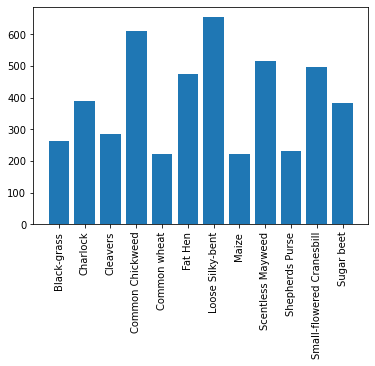

In [7]:
plt.bar(classes.keys(), classes.values())
plt.xticks(rotation=90)

In [8]:
train = []

for species_num, species in enumerate(classes):
    for file in os.listdir(os.path.join(TRAIN_IMG_PATH, species)):
        train.append(['./train/{}/{}'.format(species, file), species_num, species])
        
train = pd.DataFrame(train, columns=['file', 'species_num', 'species'])

print('Training Data: ',train.shape)

Training Data:  (4750, 3)


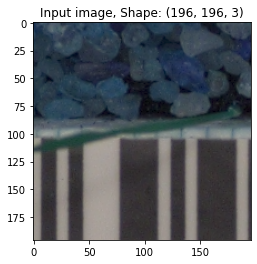

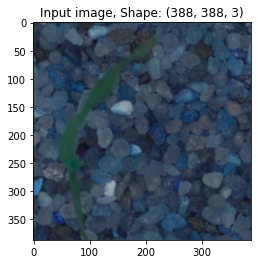

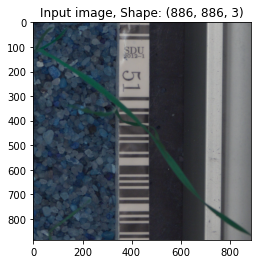

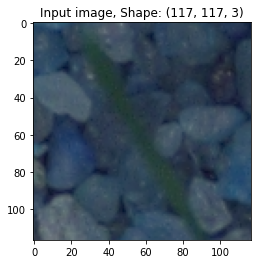

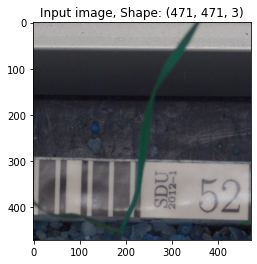

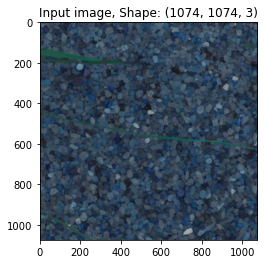

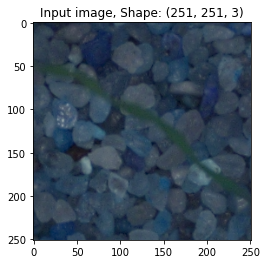

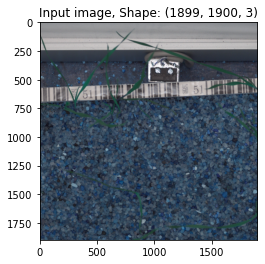

In [9]:
# Show some example images
for i in range(8):
    Input_image = cv2.imread(train['file'][i])
    plt.imshow(Input_image)
    plt.title('Input image, Shape: '+str(Input_image.shape))
    plt.show()



## Clean and Pre Process Data

In [10]:
def create_mask_for_plant(image):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    sensitivity = 35
    lower_hsv = np.array([60 - sensitivity, 100, 50])
    upper_hsv = np.array([60 + sensitivity, 255, 255])

    mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    return mask

In [11]:
%%time

trainImg = []

for i in range(len(train)):
    img = cv2.imread(train['file'][i])
    img = cv2.resize(img,dsize=(128,128))
    mask = create_mask_for_plant(img)
    masked = cv2.bitwise_and(img, img, mask = mask)
    image_blurred = cv2.GaussianBlur(masked, (0, 0), 3)
    image_sharp = cv2.addWeighted(masked, 1.5, image_blurred, -0.5, 0)
    img_stack = cv2.cvtColor( image_sharp, cv2.COLOR_RGB2GRAY )
    img_stack = np.reshape(img_stack,(128,128,1))
    trainImg.append(np.concatenate((np.array(img),np.array(img_stack)),axis=2))
trainImg = np.array(trainImg)

Wall time: 43.5 s


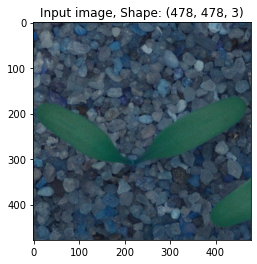

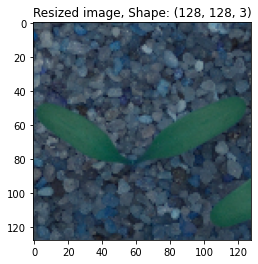

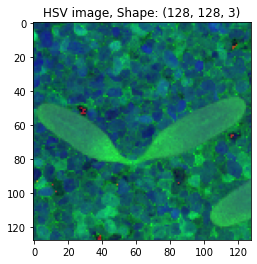

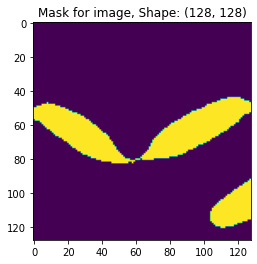

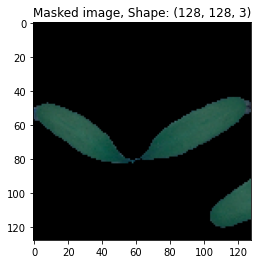

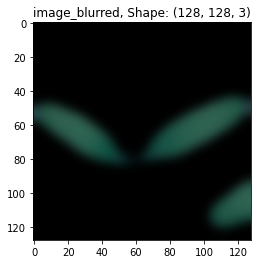

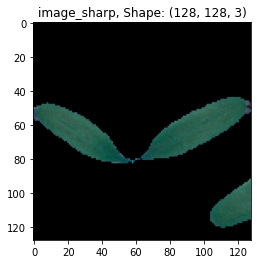

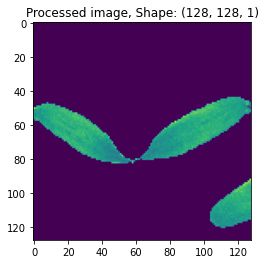

In [14]:
# Input image
Input_image = cv2.imread(train['file'][len(train)-1])

plt.imshow(Input_image)
plt.title('Input image, Shape: '+str(Input_image.shape))
plt.show()

# Resized image
plt.imshow(img)
plt.title('Resized image, Shape: '+str(img.shape))
plt.show()

# HSV image
image_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
plt.imshow(image_hsv)
plt.title('HSV image, Shape: '+str(image_hsv.shape))
plt.show()

# Mask for image
plt.imshow(mask)
plt.title('Mask for image, Shape: '+str(mask.shape))
plt.show()

# masked image
plt.imshow(masked)
plt.title('Masked image, Shape: '+str(masked.shape))
plt.show()

# image_blurred image
plt.imshow(image_blurred)
plt.title('image_blurred, Shape: '+str(image_blurred.shape))
plt.show()

# Resized image
plt.imshow(image_sharp)
plt.title('image_sharp, Shape: '+str(image_sharp.shape))
plt.show()
        
# Processed image to Stack
plt.imshow(np.reshape(img_stack,(128,128,1)))
plt.title('Processed image, Shape: '+str(img_stack.shape))
plt.show()

In [12]:
traininglabels = train['species']

In [13]:
labels = train['species_num']
labels = to_categorical(labels, num_classes = len(classes))

In [15]:
new_train = trainImg/255

Defining our model and splitting the dataset:

In [16]:
x_train, x_val, y_train, y_val = train_test_split(trainImg, labels, test_size = 0.2, random_state=10)

In [74]:
x_train_n, x_val_n, y_train_n, y_val_n = train_test_split(new_train, labels, test_size = 0.1, random_state=10)

In [17]:
input_shape = x_train[1].shape
print('Input Shape is :', input_shape)

Input Shape is : (128, 128, 4)


In [16]:
x_train.shape


(3800, 128, 128, 4)

## Model Conigurations

## Configuration 1 (2 Hidden Layers)

In [18]:
def fire_incept(x, fire=16, intercept=64, activationF = 'relu'):
    x = Conv2D(fire, (5,5), activation=activationF, strides=(2,2))(x)
    
    left = Conv2D(intercept, (3,3), activation=activationF, padding='same')(x)
    
    right = Conv2D(intercept, (5,5), activation=activationF, padding='same')(x)
    
    x = concatenate([left, right], axis=3)
    return x

def fire_squeeze(x, fire=16, intercept=64, activationF = 'relu'):
    x = Conv2D(fire, (1,1), activation=activationF)(x)
    
    left = Conv2D(intercept, (1,1), activation=activationF)(x)
    
    right = Conv2D(intercept, (3,3), activation=activationF, padding='same')(x)
    
    x = concatenate([left, right], axis=3)
    return x

In [22]:
image_input=Input(shape=input_shape)

x = fire_incept((image_input), fire=16, intercept=16, activationF = 'relu')

x = fire_incept(x, fire=32, intercept=32, activationF = 'relu')
x = fire_squeeze(x, fire=32, intercept=32, activationF = 'relu')

# x = fire_incept(x, fire=64, intercept=64, activationF = 'relu')
# x = fire_squeeze(x, fire=64, intercept=64, activationF = 'relu')

x = fire_incept(x, fire=64, intercept=64, activationF = 'relu')
x = fire_squeeze(x, fire=64, intercept=64, activationF = 'relu')

x = Conv2D(64, (3,3), activation= 'relu')(x)

x = Flatten()(x)

x = Dense(512, activation= 'relu')(x)
# x = Dropout(0.1)(x)

out = Dense(len(classes), activation='softmax')(x)

model_new = Model(image_input, out)
model_new.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 4) 0                                            
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 62, 62, 16)   1616        input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, 62, 62, 16)   2320        conv2d_16[0][0]                  
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, 62, 62, 16)   6416        conv2d_16[0][0]                  
____________________________________________________________________________________________

In [39]:
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits= 5, shuffle=True, random_state=10)

In [20]:
model_new.compile(optimizer = Adam(lr=.0001) , loss = 'categorical_crossentropy', metrics=['accuracy'])

In [67]:
datagen = ImageDataGenerator(rotation_range=180, zoom_range = 0.2, width_shift_range=0.2, height_shift_range=0.2,
                             horizontal_flip=True, vertical_flip=True)
datagen.fit(x_train_n)

In [21]:
model_new.fit(x_train, y_train, epochs=20, batch_size=32, verbose=0)
acc,scores = model_new.evaluate(x_val, y_val, verbose=0)
print("accuracy = %.2f%%" % (acc))

accuracy = 2.07%


In [27]:
model_new.compile(optimizer = Adam(lr=.001) , loss = 'categorical_crossentropy', metrics=['accuracy'])

In [24]:
model_new.fit(x_train, y_train, epochs=25, batch_size=32, verbose=0)

In [28]:
acc = model_new.evaluate(x_val, y_val, verbose=0)
print(acc)

[1.329276886237295, 0.76736844]


In [31]:
model_new.compile(optimizer = SGD(lr=.001) , loss = 'categorical_crossentropy', metrics=['accuracy'])

In [32]:
model_new.fit(x_train, y_train, epochs=20, batch_size=32, verbose=0)
acc = model_new.evaluate(x_val, y_val, verbose=0)
print(acc)

[1.4396218954889397, 0.7694737]


In [33]:
model_new.compile(optimizer = RMSprop(lr=.001) , loss = 'categorical_crossentropy', metrics=['accuracy'])

In [34]:
model_new.fit(x_train, y_train, epochs=20, batch_size=32, verbose=0)
acc = model_new.evaluate(x_val, y_val, verbose=0)
print(acc)

[2.267814762717799, 0.66842103]


In [35]:
def fire_incept(x, fire=16, intercept=64, activationF = 'tanh'):
    x = Conv2D(fire, (5,5), activation=activationF, strides=(2,2))(x)
    
    left = Conv2D(intercept, (3,3), activation=activationF, padding='same')(x)
    
    right = Conv2D(intercept, (5,5), activation=activationF, padding='same')(x)
    
    x = concatenate([left, right], axis=3)
    return x

def fire_squeeze(x, fire=16, intercept=64, activationF = 'tanh'):
    x = Conv2D(fire, (1,1), activation=activationF)(x)
    
    left = Conv2D(intercept, (1,1), activation=activationF)(x)
    
    right = Conv2D(intercept, (3,3), activation=activationF, padding='same')(x)
    
    x = concatenate([left, right], axis=3)
    return x

In [43]:
image_input=Input(shape=input_shape)

x = fire_incept((image_input), fire=16, intercept=16, activationF = 'tanh')

x = fire_incept(x, fire=32, intercept=32, activationF = 'tanh')
x = fire_squeeze(x, fire=32, intercept=32, activationF = 'tanh')

x = fire_incept(x, fire=64, intercept=64, activationF = 'tanh')
x = fire_squeeze(x, fire=64, intercept=64, activationF = 'tanh')

x = fire_incept(x, fire=64, intercept=64, activationF = 'tanh')
x = fire_squeeze(x, fire=64, intercept=64, activationF = 'tanh')

x = Conv2D(64, (3,3), activation= 'tanh')(x)

x = Flatten()(x)

x = Dense(512, activation= 'tanh')(x)
# x = Dropout(0.1)(x)

out = Dense(len(classes), activation='softmax')(x)

model_new = Model(image_input, out)
model_new.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 128, 128, 4) 0                                            
__________________________________________________________________________________________________
conv2d_48 (Conv2D)              (None, 62, 62, 16)   1616        input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_49 (Conv2D)              (None, 62, 62, 16)   2320        conv2d_48[0][0]                  
__________________________________________________________________________________________________
conv2d_50 (Conv2D)              (None, 62, 62, 16)   6416        conv2d_48[0][0]                  
____________________________________________________________________________________________

In [37]:
model_new.compile(optimizer = Adam(lr=.001) , loss = 'categorical_crossentropy', metrics=['accuracy'])

## Configuration 2 (3 Hidden Layers)

In [38]:
model_new.fit(x_train, y_train, epochs=20, batch_size=32, verbose=0)
acc = model_new.evaluate(x_val, y_val, verbose=0)
print(acc)

[2.482264734067415, 0.10210526]


In [39]:
model_new.compile(optimizer = SGD(lr=.001) , loss = 'categorical_crossentropy', metrics=['accuracy'])

In [40]:
model_new.fit(x_train, y_train, epochs=20, batch_size=32, verbose=0)
acc = model_new.evaluate(x_val, y_val, verbose=0)
print(acc)

[2.413824236518458, 0.12947369]


In [41]:
model_new.compile(optimizer = RMSprop(lr=.001) , loss = 'categorical_crossentropy', metrics=['accuracy'])

In [42]:
model_new.fit(x_train, y_train, epochs=20, batch_size=32, verbose=0)
acc = model_new.evaluate(x_val, y_val, verbose=0)
print(acc)

[2.5536834315249792, 0.10315789]


In [44]:
model_new.compile(optimizer = Adam(lr=.001) , loss = 'categorical_crossentropy', metrics=['accuracy'])

In [46]:
model_new.fit(x_train, y_train, epochs=15, batch_size=32, verbose=0)
acc = model_new.evaluate(x_val, y_val, verbose=0)
print(acc)

[2.4530157706612035, 0.12947369]


In [47]:
def fire_incept(x, fire=16, intercept=64, activationF = 'relu'):
    x = Conv2D(fire, (5,5), activation=activationF, strides=(2,2))(x)
    
    left = Conv2D(intercept, (3,3), activation=activationF, padding='same')(x)
    
    right = Conv2D(intercept, (5,5), activation=activationF, padding='same')(x)
    
    x = concatenate([left, right], axis=3)
    return x

def fire_squeeze(x, fire=16, intercept=64, activationF = 'relu'):
    x = Conv2D(fire, (1,1), activation=activationF)(x)
    
    left = Conv2D(intercept, (1,1), activation=activationF)(x)
    
    right = Conv2D(intercept, (3,3), activation=activationF, padding='same')(x)
    
    x = concatenate([left, right], axis=3)
    return x

In [48]:
image_input=Input(shape=input_shape)

x = fire_incept((image_input), fire=16, intercept=16, activationF = 'relu')

x = fire_incept(x, fire=32, intercept=32, activationF = 'relu')
x = fire_squeeze(x, fire=32, intercept=32, activationF = 'relu')

x = fire_incept(x, fire=64, intercept=64, activationF = 'relu')
x = fire_squeeze(x, fire=64, intercept=64, activationF = 'relu')

x = fire_incept(x, fire=64, intercept=64, activationF = 'relu')
x = fire_squeeze(x, fire=64, intercept=64, activationF = 'relu')

x = Conv2D(64, (3,3), activation= 'relu')(x)

x = Flatten()(x)

x = Dense(512, activation= 'relu')(x)
# x = Dropout(0.1)(x)

out = Dense(len(classes), activation='softmax')(x)

model_new = Model(image_input, out)
model_new.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 128, 128, 4) 0                                            
__________________________________________________________________________________________________
conv2d_70 (Conv2D)              (None, 62, 62, 16)   1616        input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_71 (Conv2D)              (None, 62, 62, 16)   2320        conv2d_70[0][0]                  
__________________________________________________________________________________________________
conv2d_72 (Conv2D)              (None, 62, 62, 16)   6416        conv2d_70[0][0]                  
____________________________________________________________________________________________

In [49]:
model_new.compile(optimizer = Adam(lr=.001) , loss = 'categorical_crossentropy', metrics=['accuracy'])

In [50]:
model_new.fit(x_train, y_train, epochs=15, batch_size=32, verbose=0)
acc = model_new.evaluate(x_val, y_val, verbose=0)
print(acc)

[1.2713458344810888, 0.6557895]


In [51]:
image_input=Input(shape=input_shape)

x = fire_incept((image_input), fire=16, intercept=16, activationF = 'relu')

x = fire_incept(x, fire=32, intercept=32, activationF = 'relu')
x = fire_squeeze(x, fire=32, intercept=32, activationF = 'relu')

x = fire_incept(x, fire=64, intercept=64, activationF = 'relu')
x = fire_squeeze(x, fire=64, intercept=64, activationF = 'relu')

x = fire_incept(x, fire=64, intercept=64, activationF = 'relu')
x = fire_squeeze(x, fire=64, intercept=64, activationF = 'relu')

x = Conv2D(64, (3,3), activation= 'relu')(x)

x = Flatten()(x)

x = Dense(512, activation= 'relu')(x)
x = Dropout(0.1)(x)

out = Dense(len(classes), activation='softmax')(x)

model_new = Model(image_input, out)
model_new.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 128, 128, 4) 0                                            
__________________________________________________________________________________________________
conv2d_92 (Conv2D)              (None, 62, 62, 16)   1616        input_6[0][0]                    
__________________________________________________________________________________________________
conv2d_93 (Conv2D)              (None, 62, 62, 16)   2320        conv2d_92[0][0]                  
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 62, 62, 16)   6416        conv2d_92[0][0]                  
____________________________________________________________________________________________

In [52]:
model_new.compile(optimizer = Adam(lr=.001) , loss = 'categorical_crossentropy', metrics=['accuracy'])

In [53]:
model_new.fit(x_train, y_train, epochs=15, batch_size=32, verbose=0)
acc = model_new.evaluate(x_val, y_val, verbose=0)
print(acc)

[1.1821894289317885, 0.6926316]


In [54]:
model_new.compile(optimizer = SGD(lr=.001) , loss = 'categorical_crossentropy', metrics=['accuracy'])

In [55]:
model_new.fit(x_train, y_train, epochs=15, batch_size=32, verbose=0)
acc = model_new.evaluate(x_val, y_val, verbose=0)
print(acc)

[1.3325915952732688, 0.7157895]


## Configuration 3 (4 Hidden Layers)

In [0]:
f1_scores = []
for train, test in kfold.split(rescaledX, y):
  # Model Structure
  model = Sequential()
  model.add(Dense(13, input_dim=13, activation='relu'))
  model.add(Dense(20, activation='relu'))
  model.add(Dense(20, activation='relu'))
  model.add(Dense(20, activation='relu'))
  model.add(Dense(10, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))

  # Compile the model
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

  # fit the model
  model.fit(rescaledX[train], y[train], epochs=100, batch_size=10, verbose=0)

  # evaluate model
  scores = model.evaluate(rescaledX[test], y[test], verbose=0)

  #print(scores)
  f1_scores.append(scores[1] * 100)

  
# Print F1
print("F1 Score = %.2f%% (+/- %.2f%%)" % (np.mean(f1_scores), np.std(f1_scores)))

F1 Score = 78.38% (+/- 2.20%)


## Configuration 4 (5 Hidden Layers)

In [0]:
f1_scores = []
for train, test in kfold.split(rescaledX, y):
  # Model Structure
  model = Sequential()
  model.add(Dense(13, input_dim=13, activation='relu'))
  model.add(Dense(40, activation='relu'))
  model.add(Dense(30, activation='relu'))
  model.add(Dense(20, activation='relu'))
  model.add(Dense(20, activation='relu'))
  model.add(Dense(10, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))

  # Compile the model
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

  # fit the model
  model.fit(rescaledX[train], y[train], epochs=100, batch_size=10, verbose=0)

  # evaluate model
  scores = model.evaluate(rescaledX[test], y[test], verbose=0)

  #print(scores)
  f1_scores.append(scores[1] * 100)

  
# Print F1
print("F1 Score = %.2f%% (+/- %.2f%%)" % (np.mean(f1_scores), np.std(f1_scores)))

F1 Score = 77.94% (+/- 1.52%)


## Configuration 5 (1 Hidden Layers)

In [0]:
f1_scores = []
for train, test in kfold.split(rescaledX, y):
  # Model Structure
  model = Sequential()
  model.add(Dense(13, input_dim=13, activation='relu'))
  model.add(Dense(70, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))

  # Compile the model
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

  # fit the model
  model.fit(rescaledX[train], y[train], epochs=100, batch_size=10, verbose=0)

  # evaluate model
  scores = model.evaluate(rescaledX[test], y[test], verbose=0)

  #print(scores)
  f1_scores.append(scores[1] * 100)

  
# Print F1
print("F1 Score = %.2f%% (+/- %.2f%%)" % (np.mean(f1_scores), np.std(f1_scores)))

F1 Score = 76.94% (+/- 6.54%)


## L1 Regularization with 3 Hidden Layers

In [0]:
f1_scores = []
for train, test in kfold.split(rescaledX, y):
  # Model Structure
  model = Sequential()
  model.add(Dense(13, input_dim=13, activation='relu', kernel_regularizer=regularizers.l2(0.00001)))
  model.add(Dense(20, activation='relu', kernel_regularizer=regularizers.l2(0.00001)))
  model.add(Dense(20, activation='relu', kernel_regularizer=regularizers.l2(0.00001)))
  model.add(Dense(10, activation='relu', kernel_regularizer=regularizers.l2(0.00001)))
  model.add(Dense(1, activation='sigmoid'))

  # Compile the model
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

  # fit the model
  model.fit(rescaledX[train], y[train], epochs=100, batch_size=10, verbose=0)

  # evaluate model
  scores = model.evaluate(rescaledX[test], y[test], verbose=0)

  #print(scores)
  f1_scores.append(scores[1] * 100)

  
# Print F1
print("F1 Score = %.2f%% (+/- %.2f%%)" % (np.mean(f1_scores), np.std(f1_scores)))

F1 Score = 77.65% (+/- 1.96%)


## L2 Regularization with 3 Hidden Layers

In [0]:
f1_scores = []
for train, test in kfold.split(rescaledX, y):
  # Model Structure
  model = Sequential()
  model.add(Dense(13, input_dim=13, activation='relu', kernel_regularizer=regularizers.l1(0.00001)))
  model.add(Dense(20, activation='relu', kernel_regularizer=regularizers.l1(0.00001)))
  model.add(Dense(20, activation='relu', kernel_regularizer=regularizers.l1(0.00001)))
  model.add(Dense(10, activation='relu', kernel_regularizer=regularizers.l1(0.00001)))
  model.add(Dense(1, activation='sigmoid'))

  # Compile the model
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

  # fit the model
  model.fit(rescaledX[train], y[train], epochs=100, batch_size=10, verbose=0)

  # evaluate model
  scores = model.evaluate(rescaledX[test], y[test], verbose=0)

  #print(scores)
  f1_scores.append(scores[1] * 100)

  
# Print F1
print("F1 Score = %.2f%% (+/- %.2f%%)" % (np.mean(f1_scores), np.std(f1_scores)))

F1 Score = 77.51% (+/- 2.65%)
